# Training High Dimensional Optimal Transport Benchmarks
DenseICNN-based benchmark training by using W2GN OT solver.
**GPU-only implementation.**

In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import gc

from sklearn.decomposition import PCA

from src import distributions
from src import map_benchmark as mbm

from src.icnn import DenseICNN
from src.tools import train_identity_map, unfreeze
from src.plotters import plot_benchmark_emb, plot_W2

from tqdm import tqdm
from IPython.display import clear_output

## Changable Config

In [2]:
DIM = 128
VERSION = "v2" # v1
GPU_DEVICE = 1
BATCH_SIZE = 1024

## Hardcoded Config

In [4]:
BENCHMARK = 'Mix3toMix10'
SEED = {'v1' : [0x000000, 0xBADBEEF], 'v2' : [0x000000, 0xC0FFEE]}

MAX_ITER = 500001
LAMBDA = DIM # usually works like a charm

LR = 1e-3

D_HYPERPARAMS = {
    'dim' : DIM,
    'rank' : 1,
    'hidden_layer_sizes' : [max(2*DIM, 64), max(2*DIM, 64), max(DIM, 32)],
    'strong_convexity' : 1e-4
}

OUTPUT_PATH = '../benchmarks/' + BENCHMARK
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)
torch.manual_seed(0x000000); np.random.seed(0x000000)

## Initializing input and output distributions

In [5]:
np.random.seed(SEED[VERSION][0]); torch.manual_seed(SEED[VERSION][0])
input_sampler = distributions.RandomGaussianMixSampler(dim=DIM, num=3)

np.random.seed(SEED[VERSION][1]); torch.manual_seed(SEED[VERSION][1])
output_sampler = distributions.RandomGaussianMixSampler(dim=DIM, num=10)

benchmark = mbm.Wasserstein2MapBenchmark(input_sampler, output_sampler)
emb_X = PCA(n_components=2).fit(input_sampler.sample(2**14).cpu().detach().numpy())
emb_Y = PCA(n_components=2).fit(output_sampler.sample(2**14).cpu().detach().numpy())

## Potentials Setup

In [6]:
D = DenseICNN(**D_HYPERPARAMS).cuda()
D_conj = DenseICNN(**D_HYPERPARAMS).cuda()

pretrain_sampler = distributions.StandardNormalSampler(dim=DIM)
print('Pretraining identity potential. Final MSE:', train_identity_map(D, pretrain_sampler, convex=True, blow=3))
D_conj.load_state_dict(D.state_dict())
del pretrain_sampler

Pretraining identity potential. Final MSE: 0.0009970980463549495


## Main Training

In [7]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR, weight_decay=1e-10)
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=LR, weight_decay=1e-10)

In [8]:
W2_history = []

Iteration 500000


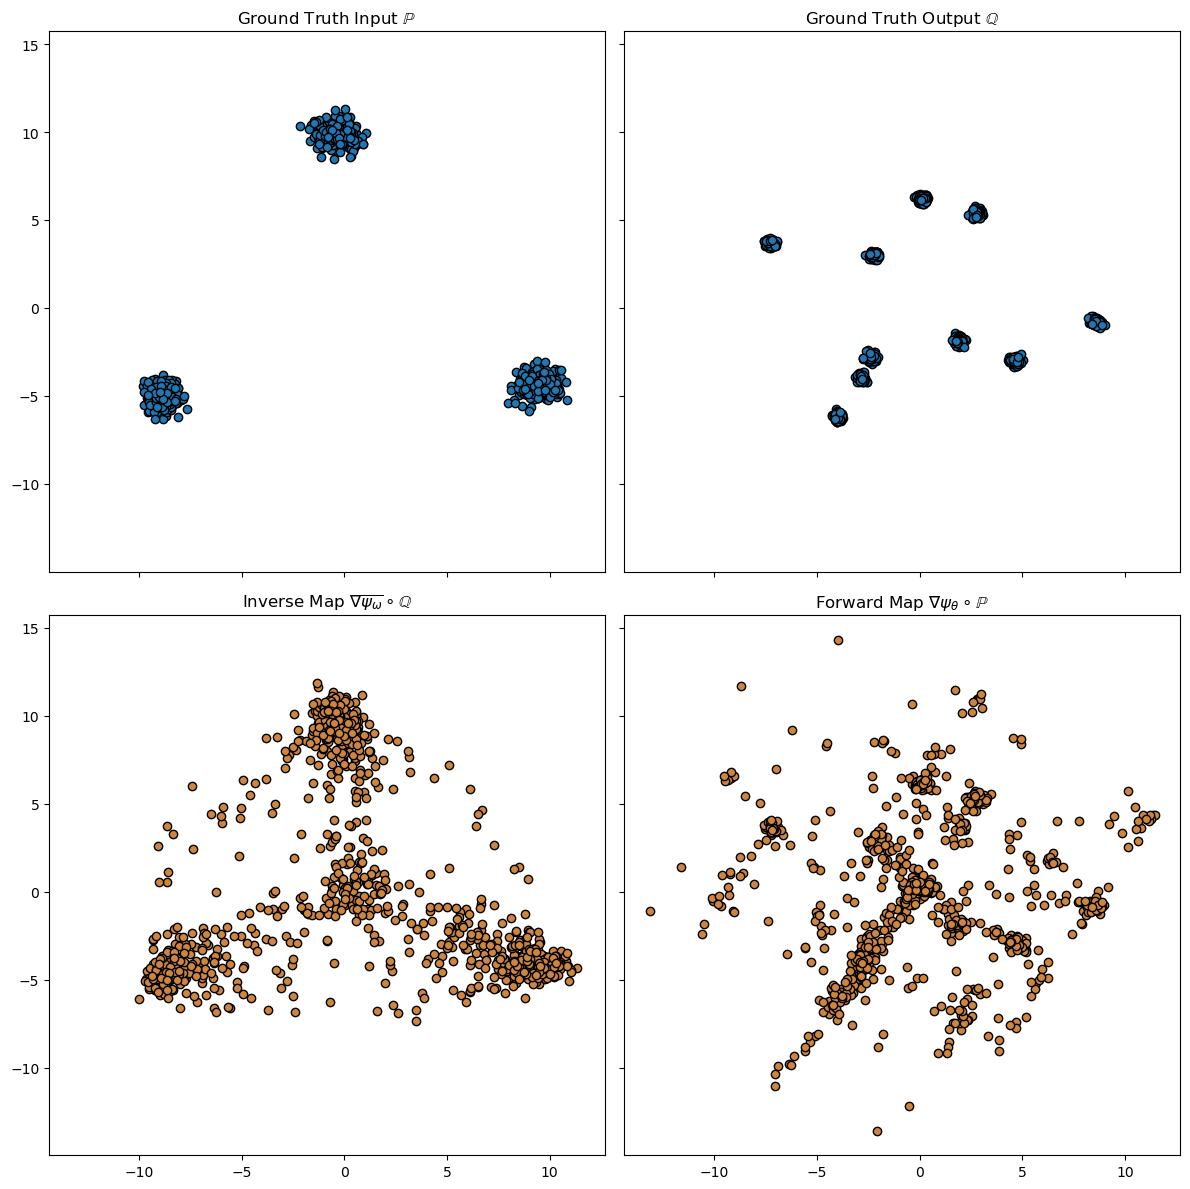

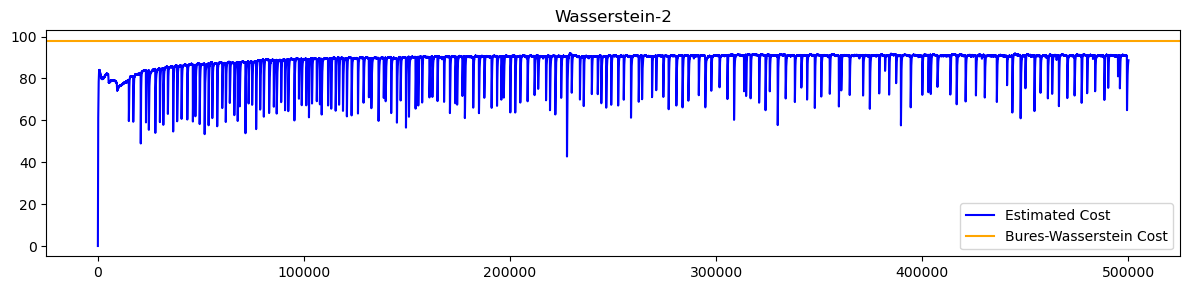

100%|████████████████████████████████████████████████████████████████████████████| 500001/500001 [5:26:59<00:00, 25.48it/s]


In [9]:
for iteration in tqdm(range(MAX_ITER)):
    unfreeze(D); unfreeze(D_conj)
    
    X = benchmark.input_sampler.sample(BATCH_SIZE)
    X.requires_grad_(True)
    Y = benchmark.output_sampler.sample(BATCH_SIZE)
    Y.requires_grad_(True)

    # Negative Wasserstein distance
    Y_inv = D_conj.push(Y).detach()
    D_opt.zero_grad(); D_conj_opt.zero_grad()  
    W_loss = (D(X) - D(Y_inv)).mean()
    
    # Cycle Regularization
    cycle_loss = ((D.push(D_conj.push(Y)) - Y.detach()) ** 2).mean()
    cycle_loss += ((D_conj.push(D.push(X)) - X.detach()) ** 2).mean()
    W_loss += LAMBDA * cycle_loss
    
    # Non-backpropagated part (to monitor the convergence)
    with torch.no_grad():
        W_loss_nograd = (- (X ** 2).sum(dim=1) / 2).mean() +\
        ((Y_inv * Y).sum(dim=1) - (Y_inv ** 2).sum(dim=1) / 2 ).mean()
    
    W2_history.append(-W_loss.item() - W_loss_nograd.item())

    W_loss.backward()
    D_opt.step(); D_conj_opt.step()
    D.convexify(); D_conj.convexify()
    
    if iteration % 1000 == 0:
        clear_output(wait=True)
        print("Iteration", iteration)
        
        fig, axes = plot_benchmark_emb(benchmark, emb_X, emb_Y, D, D_conj)
        plt.show(fig); plt.close(fig)
        
        fig, ax = plot_W2(benchmark, W2_history)
        plt.show(fig); plt.close(fig)

In [10]:
print(f'Saving benchmark model checkpoints to {OUTPUT_PATH}')
D.convexify(); D_conj.convexify()
torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'{DIM}_{VERSION}.pt'))
torch.save(D_conj.state_dict(), os.path.join(OUTPUT_PATH, f'{DIM}_{VERSION}_conj.pt'))
print('Done!')

Saving benchmark model checkpoints to ../benchmarks/Mix3toMix10
Done!
